In [3]:
from utils import read_yaml
from model_training.training_utils import  get_tokenizer
from training_datasets.dataset_utils import load_sft_dataset, load_rm_dataset
import argparse
from constants import TOKENIZER_SEPECIAL_TOKENS


config = {}
conf = read_yaml('./config.yaml')
config.update(conf["rm"])
config.update(conf["default"])

# Create a Namespace object for config
config_ns = argparse.Namespace(**config)
config_ns.model_name = config_ns.base_model_name


tokenizer, eos_token= get_tokenizer(config_ns,TOKENIZER_SEPECIAL_TOKENS)
train_ds , eval_ds = load_rm_dataset(config_ns)



HFValidationError: Repo id must be in the form 'repo_name' or 'namespace/repo_name': 'Namespace(name='LLama-2-7b_ours_oasst_sft_reward', base_model_name='meta-llama/Llama-2-7b-hf', is_abs_rm=None, adpater_name=None, train_batch=4, eval_batch=4, num_train_epochs=1, gradient_accumulation_steps=1, eval_steps=100, save_steps=100, metrics=['accuracy'], max_replies=4, dataset={'oasst_export_abs': {'val_split': 0.05, 'lang': 'en,es,de,fr', 'max_val_set': 100}}, debug_set=100, dtype='bf16', report_to='wandb', int8_training=False, int4_training=True, output_dir='output', model_name='meta-llama/Llama-2-7b-hf', pre_sft='LLama-2-7b_pre_sft', oasst_sft='LLama-2-7b_ours_oasst_sft', ranking_rm='LLama-2-7b_ours_oasst_sft_reward', gradient_checkpointing=True, adam_beta1=None, adam_beta2=0.999, adam_epsilon=None, log_steps=10, checkpoint_number='final_checkpoint', adapter_number='final_checkpoint', lr_scheduler_type='cosine', lr='1e-4', warmup_ratio=0.03, weight_decay=0.0, max_grad_norm=0.3, resume_from_checkpoint=None, checkpoint_name=None, hpt_data_frac=None, init_from_adapter=None, early_stopping=False, eval_accumulation_steps=None, max_steps=0, merged_adapter_path=None, collator={'max_length': 2048, 'random_offset_probability': 0.5, 'label_masking': True, 'samples_mixing': False, 'use_system_prefix': False, 'system_prefix': None})'. Use `repo_type` argument if needed.

In [16]:
input_lenghts=[]
for x,i in enumerate(train_ds):
    flatten_message = tokenizer(
        "".join(i),
        truncation=False,
        padding=False,
    )
    input_lenghts.append(len(flatten_message["input_ids"]))
    if x%1000==0:
        print(f'so far {x} row have been processed and max length is {max(input_lenghts)}')

so far 0 row have been processed and max length is 633
so far 1000 row have been processed and max length is 4983
so far 2000 row have been processed and max length is 4983
so far 3000 row have been processed and max length is 4983
so far 4000 row have been processed and max length is 4983
so far 5000 row have been processed and max length is 4983
so far 6000 row have been processed and max length is 4983
so far 7000 row have been processed and max length is 4983
so far 8000 row have been processed and max length is 4983
so far 9000 row have been processed and max length is 4983
so far 10000 row have been processed and max length is 4983
so far 11000 row have been processed and max length is 4983
so far 12000 row have been processed and max length is 4983
so far 13000 row have been processed and max length is 4983
so far 14000 row have been processed and max length is 5033
so far 15000 row have been processed and max length is 5033
so far 16000 row have been processed and max length is

Max source length: 783
11596


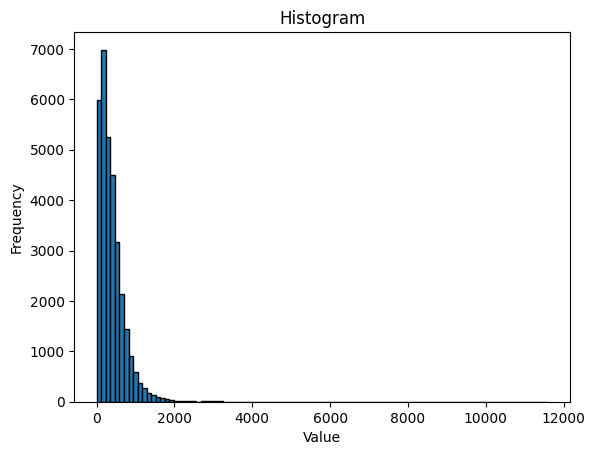

In [17]:
import numpy as np
# take 85 percentile of max length for better utilization
max_source_length = int(np.percentile(input_lenghts, 90))
print(f"Max source length: {max_source_length}")
print(max(input_lenghts))


import matplotlib.pyplot as plt

plt.hist(input_lenghts, bins=100, edgecolor='black')  # You can adjust the number of bins as needed
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.show()

In [19]:
print(len(input_lenghts))
print('max',max(input_lenghts))
print('mean',np.mean(input_lenghts))
print('median',np.median(input_lenghts))
print('25 percent',int(np.percentile(input_lenghts, 25)))

print('50 percent',int(np.percentile(input_lenghts, 50)))
print('75 percent',int(np.percentile(input_lenghts, 75)))
print('85 percent',int(np.percentile(input_lenghts, 85)))
print('90 percent',int(np.percentile(input_lenghts, 90)))
print('95 percent',int(np.percentile(input_lenghts, 95)))
print('95 percent',int(np.percentile(input_lenghts, 97)))
print('95 percent',int(np.percentile(input_lenghts, 99)))

32325
max 11596
mean 389.63764887857695
median 307.0
25 percent 154
50 percent 307
75 percent 520
85 percent 667
90 percent 783
95 percent 990
95 percent 1168
95 percent 1620


In [20]:
e_stat = {}

for i,(key,values) in enumerate(eval_ds.items()):
    print(key)
    if key not in e_stat:
        e_stat[key] = []
        
    for r in values:
        flatten_message = tokenizer(
        "".join(r),
        truncation=False,
        padding=False,
        )
        e_stat[key].append(len(flatten_message["input_ids"]))




oasst_export


In [21]:
fin = []
for key,v in e_stat.items():
    fin.extend(v)
    print(f'==== stat for {key}, len {len(v)} ===== ')
    print('max',max(v))
    print('mean',np.mean(v))
    print('median',np.median(v))
    print('25 percent',int(np.percentile(v, 25)))
    
    print('50 percent',int(np.percentile(v, 50)))
    print('75 percent',int(np.percentile(v, 75)))
    print('85 percent',int(np.percentile(v, 85)))
    print('90 percent',int(np.percentile(v, 90)))
    print('95 percent',int(np.percentile(v, 95)))

==== stat for oasst_export, len 200 ===== 
max 3598
mean 357.305
median 291.0
25 percent 156
50 percent 291
75 percent 476
85 percent 601
90 percent 715
95 percent 852


In [22]:
print(len(fin))
print('max',max(fin))
print('mean',np.mean(fin))
print('median',np.median(fin))
print('25 percent',int(np.percentile(fin, 25)))

print('50 percent',int(np.percentile(fin, 50)))
print('75 percent',int(np.percentile(fin, 75)))
print('85 percent',int(np.percentile(fin, 85)))
print('90 percent',int(np.percentile(fin, 90)))
print('95 percent',int(np.percentile(fin, 95)))

200
max 3598
mean 357.305
median 291.0
25 percent 156
50 percent 291
75 percent 476
85 percent 601
90 percent 715
95 percent 852


In [5]:
config_ns.gradient_accumulation_steps

1

In [1]:
from training_datasets.rl_dataset import get_oasst_rl

kwargs = {}

t,v =  get_oasst_rl(0.2,'',"en,es,de,fr",**kwargs)


/home/alikhan/miniconda3/envs/torch_p310_setup/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


OASST HF dataset: len(train)=20704, len(val)=5119


In [9]:
from training_datasets.dataset_utils import format_pairs

format_pairs(t[5][0],eos_token="</s>",add_initial_reply_token=True)

['<|prompter|>Creame un codigo de python basico para poder hacer un scraping a cualquier articulo de Wikipedia. El programa debe usar BeautifulSoup y debe devolver en formato JSON el titulo del articulo y la palabra mas repetida.</s>',
 '<|assistant|>']

In [5]:
t[1]

(['How would I begin training for a marathon as a man who is pretty overweight for his size and has no previous marathon or running experience? Give me a step by step process and some tips, along with encouragement at the end of your response.',
  "Here's a step-by-step process for starting your marathon training journey:\n\n1. Get a physical check-up: Before starting any new exercise program, especially if you're overweight, it's important to get a physical check-up from your doctor to make sure you're healthy enough to begin training.\n\n2. Start slow: If you've never run before, start by walking and gradually increase your walking pace and distance. As you build up your endurance, you can start incorporating short jogs into your walks.\n\n3. Set realistic goals: Start with a goal of running for 20-30 minutes at a time, 3-4 times a week. As you progress, you can gradually increase your running time and frequency.\n\n4. Invest in good shoes: Good running shoes can help prevent injury 

In [1]:
from training_datasets.rm_dataset import get_oasst_abs_rm, ListDataset
from training_datasets.dataset_utils import load_oasst
from torch import Generator


generator = Generator()
generator.manual_seed(90)
threads_per_tree = load_oasst(mode="rm",top_k=None,lang="en,es,de,fr")

def process_thread(thread):
    prefix = [m.text for m in thread]
    replies = [r for r in thread[-1].replies if r.role == "assistant" and r.rank is not None and r.labels is not None]
    replies = sorted(replies, key=lambda r: r.rank)
    return (prefix, replies)
    
# split on tree basis, messages from same tree must not end up in different splits
trees = ListDataset(threads_per_tree,)
len(trees)

8188

In [2]:
data = [process_thread(thread) for tree_threads in trees for thread in tree_threads]
desired_labels = ["violence","creativity","helpfulness","humor","toxicity","quality"]


dataset = []

bc = 0
for row in data:
    message,replies = row
    for r in replies:
        reply_text = r.text
        labels = {}

        for l in desired_labels:
            v = r.get_label_value(l)
            
            prefix = ""
            # if l in ["violence","toxicity"] and v is not None:
            #     v = 1-v
            #     # prefix = "non "

            labels[prefix+l] = v
        
        labels_list = list(labels.values())
        if not any(item is None for item in labels_list):
            dataset.append({"message":message,"reply":reply_text,"labels":labels})


len(dataset)

40893

In [74]:
dataset[2]

{'message': ['Can you write a short introduction about the relevance of the term "monopsony" in economics? Please use examples related to potential monopsonies in the labour market and cite relevant research.'],
 'reply': 'Monopsony refers to a market structure where there is only one buyer of a good or service. In the context of labor markets, a monopsony occurs when there is only one employer in a particular geographic area or industry, giving them significant power to set wages and working conditions. Research has shown that the existence of monopsonies can lead to lower wages and reduced job opportunities for workers. For example, a study by the National Bureau of Economic Research found that in industries with high levels of concentration, workers earn lower wages and are less likely to receive benefits such as health insurance.',
 'labels': {'violence': 1.0,
  'creativity': 0.0,
  'helpfulness': 0.8333333333333334,
  'humor': 0.0,
  'toxicity': 1.0,
  'quality': 0.833333333333333

In [22]:
for idx,d in enumerate(dataset):
    if d["message"][0][:13]=="Can photoshop":
        print(idx)
        break


722


In [10]:
idx = 0
inc = 1000

v3_wgt = {"violence": 0, "creativity": 0.15, "helpfulness": 0.35, "humor": 0, "toxicity": -0.1,"quality": 0.4}
v32wgt = {"violence": 0, "creativity": 0.15, "helpfulness": 0.3, "humor": 0, "toxicity": -0.15,"quality": 0.4}

qlty = {"violence": 0, "creativity": 0, "helpfulness": 0, "humor": 0, "toxicity": 0,"quality": 1}
mean = {"violence": -0.167, "creativity": 0.167, "helpfulness": 0.167, "humor": 0.167, "toxicity": -0.167,"quality": 0.165}
v4_wgt = {"violence": -0.1, "creativity": 0.2, "helpfulness": 0.1, "humor": 0.167, "toxicity": -0.1,"quality": 0.3}
v2_wgt = {"violence": -0.05, "creativity": 0.15, "helpfulness": 0.25, "humor": 0.05, "toxicity": -0.1, "quality": 0.4
}

# for d in dataset[idx:idx+inc]:

#     print(f'message: {d["message"]}')
#     print(f'reply: {d["reply"][:20]}')
#     print(f'labels: {d["labels"]}')
    
#     for i,wgt in enumerate([v3_wgt,v32wgt,v2_wgt,v4_wgt,mean,qlty]):
#         agg = sum(d["labels"][label] * wgt[label] for label in v3_wgt)
#         print(f'aggregated scalar score {i+1} is {agg}')
#     print('===')
c = 0
for d in dataset[idx:idx+inc]:
    agg = sum(d["labels"][label] * v32wgt[label] for label in v32wgt)
    if agg < 0.09:
        c +=1
        print(f'message: {d["message"]}')
        print(f'reply: {d["reply"]}')
        print(f'labels: {d["labels"]}')
        print(agg)
        print('=======')



c

message: ['I want to start doing astrophotography as a hobby, any suggestions what could i do?']
reply: buy a telescope
go to the planetarium
buy a specificaly designed star catching camera
labels: {'violence': 0.0, 'creativity': 0.25, 'helpfulness': 0.0, 'humor': 0.0, 'toxicity': 0.0, 'quality': 0.05}
0.0575
message: ["I'm creating a NodeJS backend using Express, and I'm getting the following error:\n`Uncaught TypeError: Cannot read properties of undefined (reading 'id')`\n\nMy code of where this error is happening is as follows:\n```\napp.delete('/post', (req, res) => {\n    const user = getUser(req.user.user_id);\n    if (!user) return res.sendStatus(401);\n    const post = getPost(req.body.id);\n    if (!post) return res.sendStatus(404);\n    if (post.user_id != req.user.user_id) return res.sendStatus(403);\n    // Code that deletes the post through DB\n    return res.sendStatus(201);\n});\n```\n\nWhat are ways I can fix this error?"]
reply: There is insufficient data to provide a 

20

In [44]:
desired_labels = ["violence","creativity","helpfulness","humor","toxicity","quality"]

for r in replies:
    for l in desired_labels:
        v = r.get_label_value(l)
        print(l,v)
    print('==',r.text[:10],r.rank)

violence 0.0
creativity 0.375
helpfulness 0.75
humor 0.375
toxicity 0.375
quality 0.9166666666666666
== "Monopsony 0
violence 0.16666666666666666
creativity 0.25
helpfulness 0.9166666666666666
humor 0.16666666666666666
toxicity 0.25
quality 0.8333333333333334
== Monopsony  1
violence 0.0
creativity 0.0
helpfulness 0.8333333333333334
humor 0.0
toxicity 0.0
quality 0.8333333333333334
== Monopsony  2


In [45]:
print(message,[r.text for r in replies])

['Can you write a short introduction about the relevance of the term "monopsony" in economics? Please use examples related to potential monopsonies in the labour market and cite relevant research.'] ['"Monopsony" refers to a market structure where there is only one buyer for a particular good or service. In economics, this term is particularly relevant in the labor market, where a monopsony employer has significant power over the wages and working conditions of their employees. The presence of a monopsony can result in lower wages and reduced employment opportunities for workers, as the employer has little incentive to increase wages or provide better working conditions.\n\nRecent research has identified potential monopsonies in industries such as retail and fast food, where a few large companies control a significant portion of the market (Bivens & Mishel, 2013). In these industries, workers often face low wages, limited benefits, and reduced bargaining power, leading to a situation w

In [38]:
dataset[0]

{'message': ['Can you write a short introduction about the relevance of the term "monopsony" in economics? Please use examples related to potential monopsonies in the labour market and cite relevant research.'],
 'reply': '"Monopsony" refers to a market structure where there is only one buyer for a particular good or service. In economics, this term is particularly relevant in the labor market, where a monopsony employer has significant power over the wages and working conditions of their employees. The presence of a monopsony can result in lower wages and reduced employment opportunities for workers, as the employer has little incentive to increase wages or provide better working conditions.\n\nRecent research has identified potential monopsonies in industries such as retail and fast food, where a few large companies control a significant portion of the market (Bivens & Mishel, 2013). In these industries, workers often face low wages, limited benefits, and reduced bargaining power, le

In [75]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

desired_labels = ['labels.'+d for d in desired_labels]
# desired_labels = ["violence","creativity","helpfulness","humor","toxicity","quality"]

# Convert data to pandas DataFrame
df = pd.json_normalize(dataset,)
df

,message,reply,labels.violence,labels.creativity,labels.helpfulness,labels.humor,labels.toxicity,labels.quality
0,[Can you write a short introduction about the ...,"""Monopsony"" refers to a market structure where...",1.000000,0.375000,0.750000,0.375000,0.6250,0.916667
1,[Can you write a short introduction about the ...,Monopsony is a market structure in which there...,0.833333,0.250000,0.916667,0.166667,0.7500,0.833333
2,[Can you write a short introduction about the ...,Monopsony refers to a market structure where t...,1.000000,0.000000,0.833333,0.000000,1.0000,0.833333
3,[¿CUales son las etapas del desarrollo y en qu...,Jean Piaget fue un psicólogo suizo que propuso...,0.875000,0.750000,0.937500,0.312500,0.8750,0.937500
4,[¿CUales son las etapas del desarrollo y en qu...,"Según Jean Piaget, estas son las 4 etapas del ...",1.000000,0.583333,0.916667,0.166667,1.0000,0.812500
...,...,...,...,...,...,...,...,...
29906,[I've recently started playing the turn-based ...,'Perfect information' in this context means th...,1.000000,0.000000,1.000000,0.000000,1.0000,0.666667
29907,[I've recently started playing the turn-based ...,"In the context of Into the Breach, ""perfect in...",1.000000,0.000000,0.916667,0.000000,1.0000,0.916667
29908,[Traduce el siguiente texto a chino: Buenos dí...,"早上好，请问 x 的价格是多少？(Zǎo shàng hǎo, qǐng wèn x de ...",1.000000,0.333333,0.833333,0.000000,1.0000,0.500000
29909,[Traduce el siguiente texto a chino: Buenos dí...,早上好，價格是多少,1.000000,0.333333,0.916667,0.250000,1.0000,0.916667


In [76]:
# Get descriptive statistics
desc_stats = df.describe()
print(desc_stats)


       labels.violence  labels.creativity  labels.helpfulness  labels.humor  \
count     29911.000000       29911.000000        29911.000000  29911.000000   
mean          0.955345           0.388260            0.703809      0.173546   
std           0.095667           0.244732            0.251160      0.193523   
min           0.000000           0.000000            0.000000      0.000000   
25%           0.937500           0.250000            0.583333      0.000000   
50%           1.000000           0.375000            0.750000      0.125000   
75%           1.000000           0.562500            0.916667      0.250000   
max           1.000000           1.000000            1.000000      1.000000   

       labels.toxicity  labels.quality  
count     29911.000000    29911.000000  
mean          0.889324        0.682382  
std           0.134156        0.220903  
min           0.000000        0.000000  
25%           0.833333        0.583333  
50%           0.916667        0.750000  
7

labels.violence


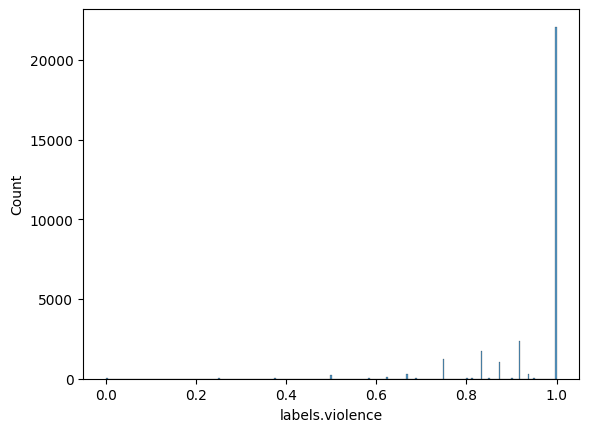

labels.creativity


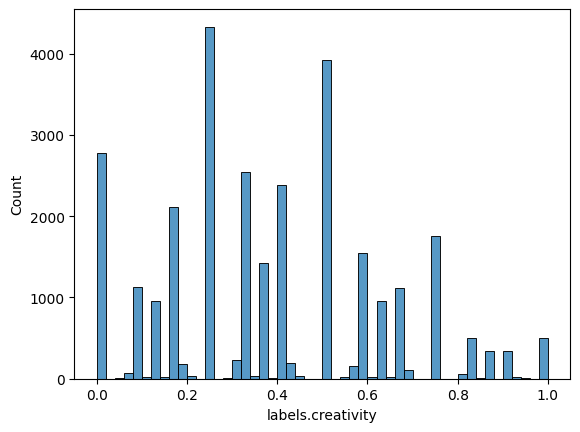

labels.helpfulness


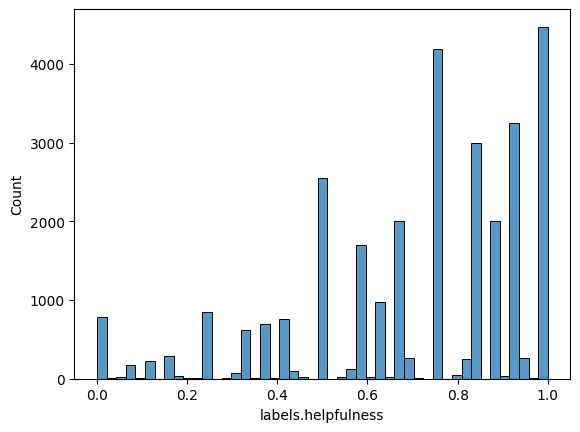

labels.humor


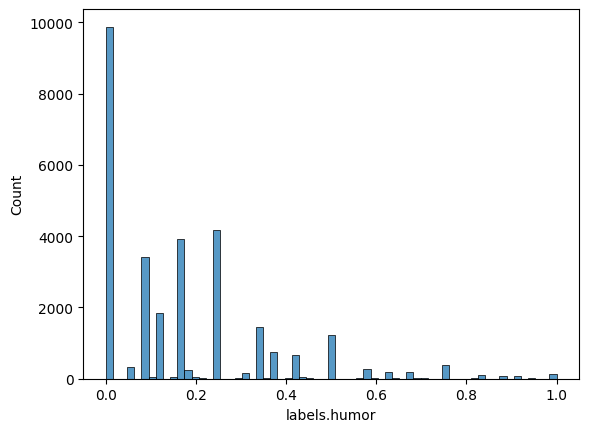

labels.toxicity


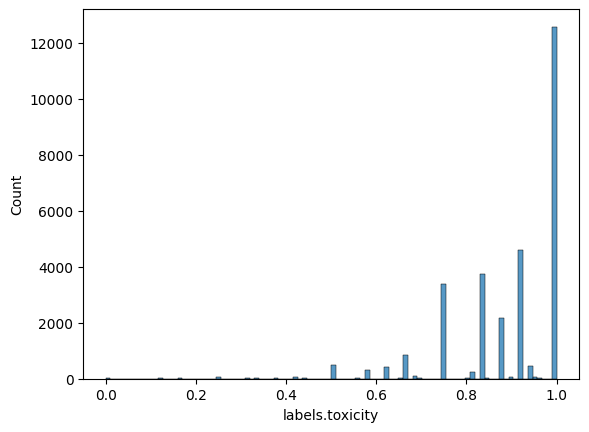

labels.quality


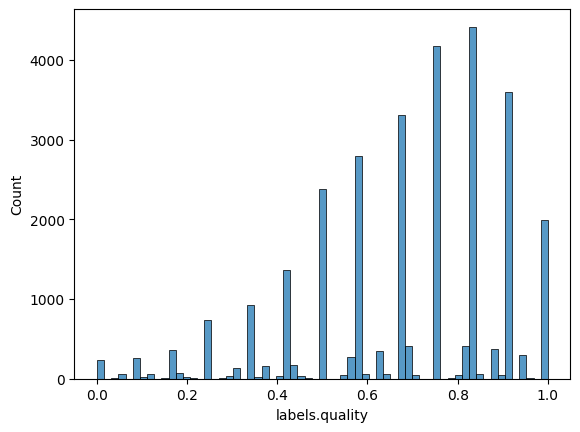

In [77]:
# Visualize the distribution of scores for each label
for col in desired_labels:
    print(col)
    sns.histplot(df[col])
    plt.show()


                    labels.violence  labels.creativity  labels.helpfulness  \
labels.violence            1.000000          -0.093237            0.130061   
labels.creativity         -0.093237           1.000000            0.327893   
labels.helpfulness         0.130061           0.327893            1.000000   
labels.humor              -0.256542           0.447679           -0.075803   
labels.toxicity            0.523532          -0.048978            0.174401   
labels.quality             0.140651           0.336266            0.779226   

                    labels.humor  labels.toxicity  labels.quality  
labels.violence        -0.256542         0.523532        0.140651  
labels.creativity       0.447679        -0.048978        0.336266  
labels.helpfulness     -0.075803         0.174401        0.779226  
labels.humor            1.000000        -0.321850       -0.073890  
labels.toxicity        -0.321850         1.000000        0.209786  
labels.quality         -0.073890         0.20

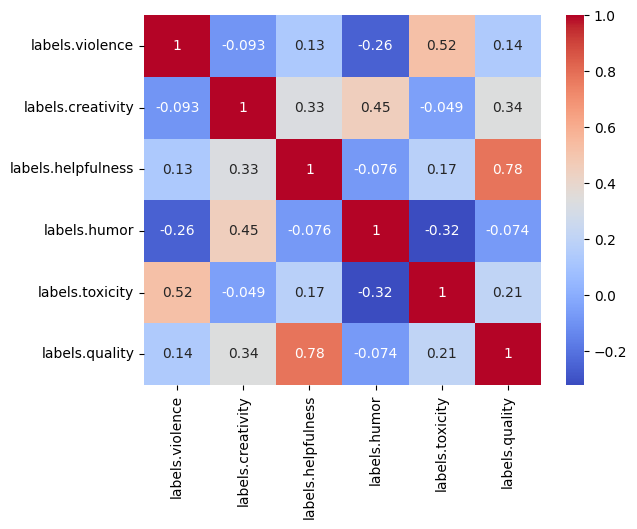

In [78]:
# Calculate the correlation coefficients among the labels
correlations = df[desired_labels].corr()
print(correlations)

# Visualize the correlations using a heatmap
sns.heatmap(correlations, annot=True, cmap='coolwarm')
plt.show()

In [41]:
# Identify and visualize missing or zero values across labels
missing_values = df[desired_labels].isnull().sum()
print(missing_values)

print('zeros')
zero_values = (df[desired_labels] == 0).sum()
print(zero_values)

violence       682
creativity     803
helpfulness    798
humor          680
toxicity       682
quality        453
dtype: int64
zeros
violence          18
creativity      4006
helpfulness     1105
humor          13667
toxicity          33
quality          320
dtype: int64


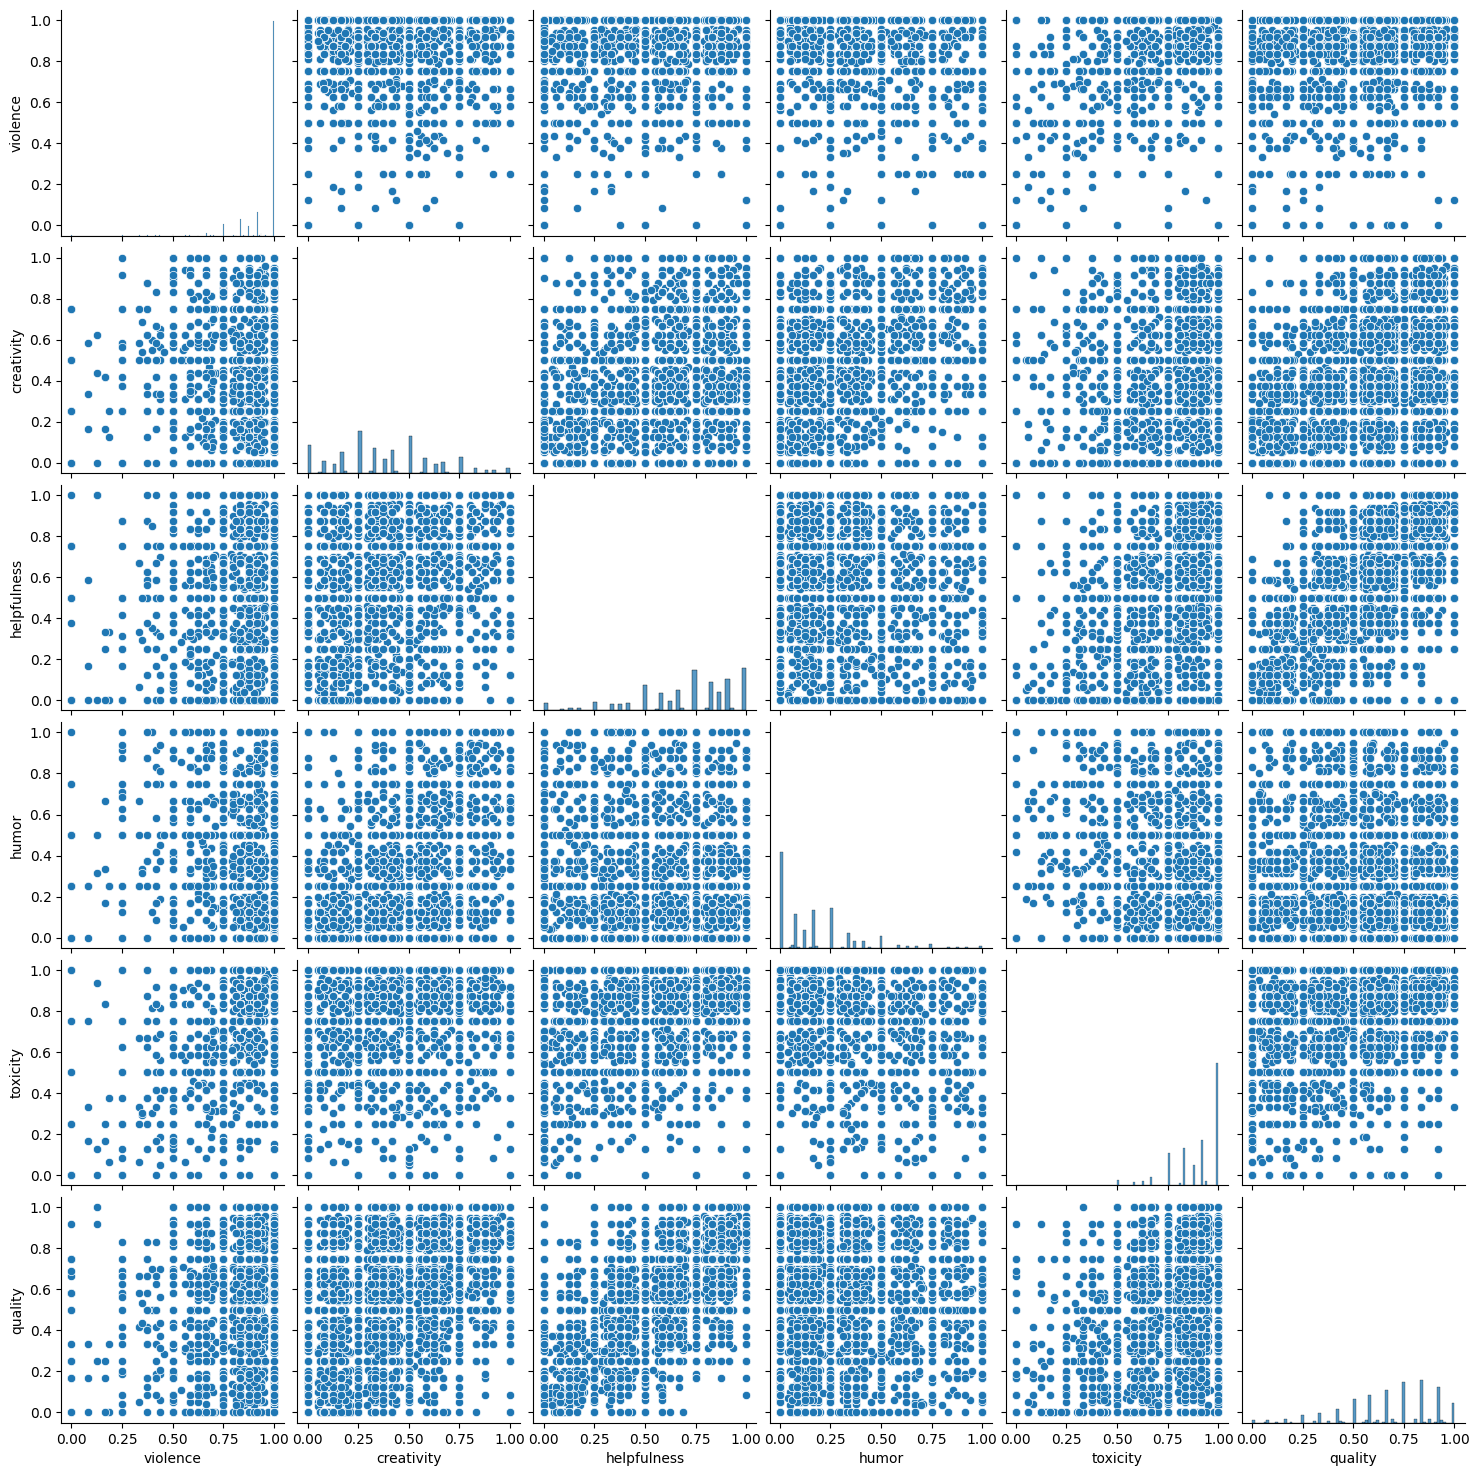

In [42]:
# Explore the relationships among multiple labels using pair plots
sns.pairplot(df[desired_labels])
plt.show()

In [49]:
df.head()

,reply,violence,creativity,helpfulness,humor,toxicity,quality
0,"""Monopsony"" refers to a market structure where...",1.000000,0.375,0.750000,0.375000,0.625,0.916667
1,Monopsony is a market structure in which there...,0.833333,0.250,0.916667,0.166667,0.750,0.833333
2,Monopsony refers to a market structure where t...,1.000000,0.000,0.833333,0.000000,1.000,0.833333
3,Here are some potential regulatory options to ...,1.000000,0.000,0.375000,0.000000,0.875,0.583333
4,Regulatory intervention can be used to address...,1.000000,0.000,0.250000,0.000000,1.000,0.250000


# RL

In [14]:
from utils import read_yaml
from model_training.training_utils import  get_tokenizer
from training_datasets.dataset_utils import load_rl_dataset, format_pairs
import argparse
from constants import TOKENIZER_SEPECIAL_TOKENS
import os
import transformers

config = {}
conf = read_yaml('./config.yaml')
config.update(conf["default"])
config.update(conf["rl"])


# Create a Namespace object for config
config_ns = argparse.Namespace(**config)
config_ns.model_name =  os.path.join(config_ns.model_name,'merged')
config_ns.debug = False

print(config_ns.dataset["oasst_export"]["lang"])
tokenizer = transformers.AutoTokenizer.from_pretrained(config_ns.model_name, cache_dir='cache')
train_ds , eval_ds = load_rl_dataset(config_ns)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


en,es,de,fr
OASST HF dataset: len(train)=24548, len(val)=1275
Size of oasst_export training data: 24548
Size of oasst_export validation data: 1275


In [15]:
input_lenghts=[]
for i,x in enumerate(train_ds):
    query = "".join(format_pairs(x, TOKENIZER_SEPECIAL_TOKENS["llama"]["eos_token"], add_initial_reply_token=True))
    flatten_message = tokenizer(
        "".join(x),
        truncation=False,
        padding=False,
    )
    input_lenghts.append(len(flatten_message["input_ids"]))
    if i%1000==0:
        print(f'so far {i} row have been processed and max length is {max(input_lenghts)}')

so far 0 row have been processed and max length is 53


so far 1000 row have been processed and max length is 3425
so far 2000 row have been processed and max length is 3425
so far 3000 row have been processed and max length is 3425
so far 4000 row have been processed and max length is 3425
so far 5000 row have been processed and max length is 3425
so far 6000 row have been processed and max length is 3425
so far 7000 row have been processed and max length is 3425
so far 8000 row have been processed and max length is 3425
so far 9000 row have been processed and max length is 3425
so far 10000 row have been processed and max length is 3425
so far 11000 row have been processed and max length is 3425
so far 12000 row have been processed and max length is 3425
so far 13000 row have been processed and max length is 5262
so far 14000 row have been processed and max length is 5262
so far 15000 row have been processed and max length is 5262
so far 16000 row have been processed and max length is 5262
so far 17000 row have been processed and max leng

In [4]:
new_input_lenghts = [2048 if x > 2048 else x for x in input_lenghts]

Max source length: 1009
5262


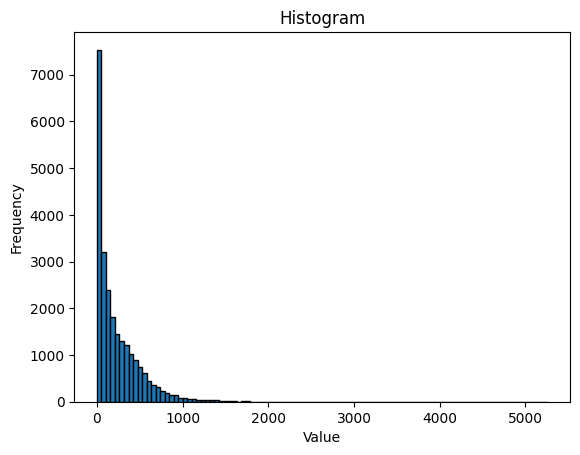

In [19]:
import numpy as np
# take 85 percentile of max length for better utilization
max_source_length = int(np.percentile(input_lenghts, 98))
print(f"Max source length: {max_source_length}")
print(max(input_lenghts))


import matplotlib.pyplot as plt

plt.hist(input_lenghts, bins=100, edgecolor='black')  # You can adjust the number of bins as needed
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.show()

Max source length: 1197
2048


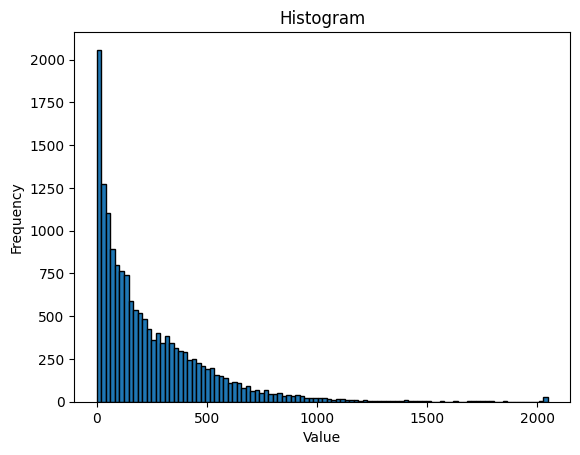

In [9]:
import numpy as np
# take 85 percentile of max length for better utilization
max_source_length = int(np.percentile(new_input_lenghts, 99))
print(f"Max source length: {max_source_length}")
print(max(new_input_lenghts))


import matplotlib.pyplot as plt

plt.hist(new_input_lenghts, bins=100, edgecolor='black')  # You can adjust the number of bins as needed
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.show()

In [13]:
c = 0
cc = 0
for nl in new_input_lenghts:
    if nl > 1536 and nl < 2048:
        c += 1
        print(nl)
    if nl == 2048:
        cc += 1
c,cc

1549
1747
1803
1741
1753
1735
1982
1695
2020
2020
2000
1574
1848
1621
1676
1787
1622
1802
1563
1850
1896
1607
1576
1722
1744
1769
1701
1792
1754
1682
1704
1695
1764
1697
1752
1560
1790
1799
1691
1632


(40, 28)

In [22]:
c = 0
for nl in input_lenghts:
    if nl <= 1024:
        c += 1
c

24084

In [50]:
2048-512

1536

In [7]:
text = """Here's a rap version of the country song:

Tone: Tired, Reflective
Title: The Long Road

(Verse 1)
Buckle up, gear up, roll up, rollin'
Another day, another mile, I'm rollin'
Been a long time since I've had a rest
All I wanna do is get away from this mess

(Chorus)
On the long road, it's a heavy load
Day in, day out, same old routine
But someday, I'll find my way
To a place that's green

(Verse 2)
I dream of a small town, with a porch swing
Where the crickets chirp, and the birds sing
I'll find a place to call my own
A little slice of heaven, that's my home

(Chorus)
On the long road, it's a heavy load
Day in, day out, same old routine
But someday, I'll find my way
To a place that's green

(Bridge)
Sometimes it feels like I'm stuck in the mud
But I know I gotta keep moving, it's in my blood
I'll keep on driving, until I reach that place
Where I can finally put a smile on my face

(Chorus)
On the long road, it's a heavy load
Day in, day out, same old routine
But someday, I'll find my way
To a place that's green

(Outro)
I'll keep on truckin', until I find my way
To a place where I can finally stay
The long road may be tough, but it's alright
Because someday, I'll see the light."""

In [8]:
import transformers

tokenizer = transformers.AutoTokenizer.from_pretrained("output/sft/LLama-2-7b_crs_oasst_sft_bs64/merged")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [9]:
len(tokenizer(text).input_ids)

412